In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas_profiling as ppf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import gc

pd.set_option('display.max_columns', 50)

In [2]:
train = pd.read_csv('.\\data\\first_round_training_data.csv')
test = pd.read_csv('.\\data\\first_round_testing_data.csv')
submit_example = pd.read_csv('.\\data\\submit_example.csv')

print('shape of train:', train.shape)
print('shape of test:', test.shape)
print('shape of submit:', submit_example.shape)

shape of train: (6000, 21)
shape of test: (6000, 11)
shape of submit: (120, 5)


In [3]:
train.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,6.856075,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.000362,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.022201,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.459004,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,11.576647,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail


In [4]:
test.head().append(test.tail())

,Group,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9
0,0,0.235279,0.195680,0.351488,0.186814,0.086456,1.434060,1.230409,0.038483,2.931083,2.005852
1,0,0.043799,0.523976,32.590688,0.886285,29.702490,0.027434,0.016852,0.600827,0.118077,887.611257
2,0,21.466737,0.523976,11.847792,79499.554454,13544.605343,0.027434,0.016852,0.600827,0.118077,887.611257
3,0,0.703795,0.010192,0.018080,317.015599,38.087562,0.428092,0.314162,0.038483,17.850021,0.051850
4,0,10.447960,0.010192,15.983891,0.996049,16.715690,0.477823,0.464037,0.038483,17.850021,0.051850
5995,119,765.876721,51.944717,0.053836,0.258969,0.125856,0.000218,0.000414,2286.523413,0.035407,0.593081
5996,119,0.071211,0.195680,0.924208,284.265495,15.668770,3.095123,1.817391,0.600827,17.850021,6.783967
5997,119,0.001922,0.073078,7.829744,16.138304,0.000376,0.741630,1.495371,0.600827,17.850021,0.051850
5998,119,0.000054,0.027291,0.672029,0.002134,0.149019,3.454681,3.262468,0.600827,17.850021,6.783967
5999,119,1.026527,0.073078,0.116152,2.923321,610.091923,1.031282,0.833011,0.038483,2.931083,2.005852


In [5]:
submit_example.head()

,Group,Excellent ratio,Good ratio,Pass ratio,Fail ratio
0,0,0.4,0.2,0.2,0.2
1,1,0.4,0.2,0.2,0.2
2,2,0.4,0.2,0.2,0.2
3,3,0.4,0.2,0.2,0.2
4,4,0.4,0.2,0.2,0.2


In [7]:
features = ['Parameter1', 'Parameter2', 'Parameter3', 'Parameter4', 'Parameter5',
            'Parameter6', 'Parameter7', 'Parameter8', 'Parameter9', 'Parameter10',
            'Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
            'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10']
test_features = ['Parameter1', 'Parameter10', 'Parameter2', 'Parameter3',
                 'Parameter4', 'Parameter5', 'Parameter6', 'Parameter7', 
                 'Parameter8', 'Parameter9']

for feature in features:
    train[feature] = np.log1p(train[feature])
    
for feature in test_features:
    test[feature] = np.log1p(test[feature])

# trainX = MinMaxScaler().fit_transform(train[test_features])
# trainX = pd.DataFrame(trainX, columns=test_features)

In [8]:
train.shape

(6000, 21)

In [ ]:
pfr = ppf.ProfileReport(train)
pfr.to_file('train_EDA.html')

In [77]:
test.Group.value_counts().unique()

array([50], dtype=int64)

### 异常点观察

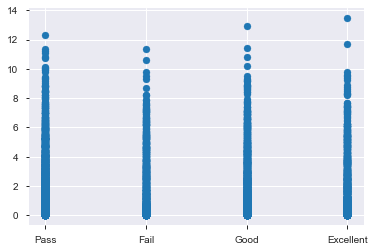

In [9]:
plt.scatter(train.Quality_label, train.Parameter1)
# 剔除train.Parameter1>12的数据

In [10]:
train = train[train.Parameter1<=12]

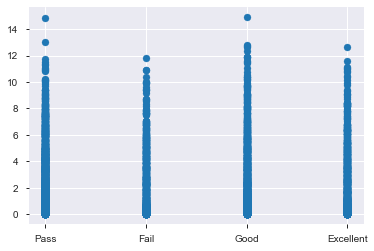

In [11]:
plt.scatter(train.Quality_label, train.Parameter2)
# 剔除train.Parameter2>14的数据

In [12]:
train = train[train.Parameter2<=14]

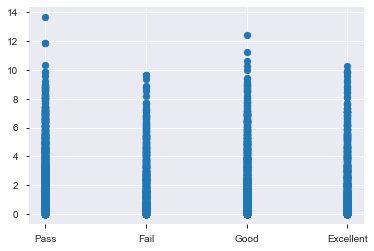

In [13]:
plt.scatter(train.Quality_label, train.Parameter3)
# 剔除train.Parameter3>12的数据

In [14]:
train = train[train.Parameter3<=12]

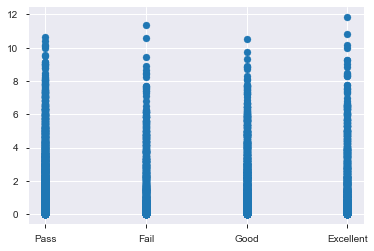

In [15]:
plt.scatter(train.Quality_label, train.Parameter4)

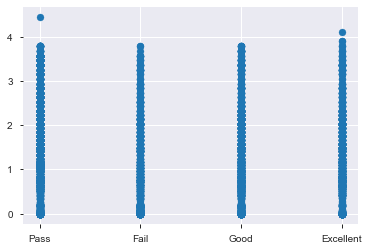

In [16]:
plt.scatter(train.Quality_label, train.Parameter5)
# 剔除train.Parameter5>4的数据

In [17]:
train = train[train.Parameter5<=4]

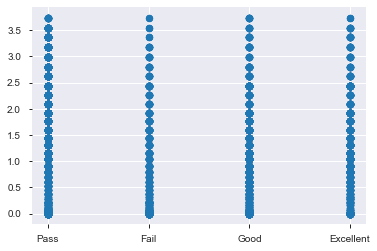

In [18]:
plt.scatter(train.Quality_label, train.Parameter6)

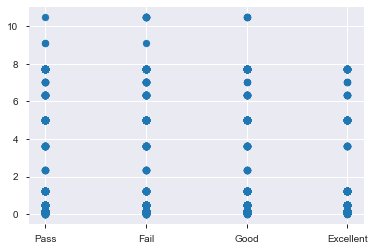

In [19]:
plt.scatter(train.Quality_label, train.Parameter7)

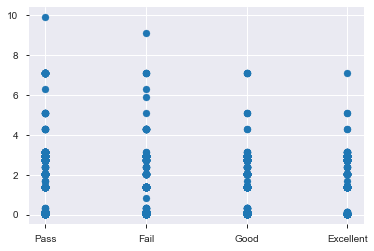

In [20]:
plt.scatter(train.Quality_label, train.Parameter8)
# 剔除train.Parameter8>8的数据

In [21]:
train = train[train.Parameter8<=8]

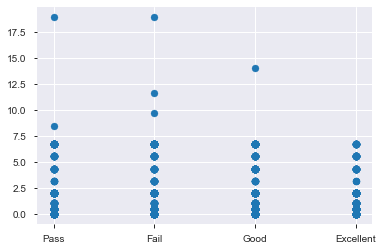

In [22]:
plt.scatter(train.Quality_label, train.Parameter9)
# 剔除train.Parameter9>12的数据

In [23]:
train = train[train.Parameter9<=10]

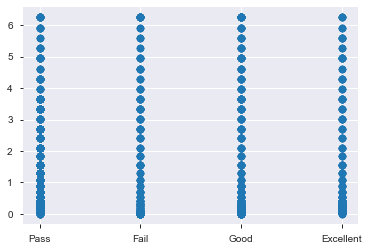

In [24]:
plt.scatter(train.Quality_label, train.Parameter10)

### 构建数据组合

In [25]:
full = pd.concat([train[test_features], test[test_features]], ignore_index=True)
full.shape

(11985, 10)

In [26]:
full.head()

,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9
0,0.001659,0.698326,0.464371,5.001314,3.668328,0.000421,0.000612,7.735225,0.034795,0.46567
1,0.956184,0.698326,0.014940,0.035236,3.953747,0.000909,0.002394,7.735225,0.034795,0.46567
2,0.093526,0.698326,4.251828,0.077813,0.106399,0.000909,0.001970,7.735225,0.034795,0.46567
3,2.953965,0.698326,0.046239,0.017900,0.741033,0.000909,0.002394,7.735225,0.034795,0.46567
4,0.012013,0.698326,0.008711,0.005493,6.264022,0.000909,0.002394,7.735225,0.034795,0.46567


In [27]:
full.to_pickle('full1.pkl')

#### 数据预处理

In [28]:
full2 = PolynomialFeatures().fit_transform(full)

In [29]:
full2 = pd.DataFrame(full2[:,1:])

In [30]:
full2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0.001659,0.698326,0.464371,5.001314,3.668328,0.000421,0.000612,7.735225,0.034795,0.46567,0.000003,0.001158,0.000770,0.008296,0.006085,6.986032e-07,0.000001,0.012831,0.000058,0.000772,0.48766,0.324282,3.492549,2.561690,0.000294,...,0.003060,38.686293,0.174019,2.328962,13.456633,0.001545,0.002244,28.375345,0.127639,1.708231,1.773791e-07,2.576873e-07,0.003258,0.000015,0.000196,3.743550e-07,0.004733,0.000021,0.000285,59.833706,0.269145,3.602062,0.001211,0.016203,0.216849
1,0.956184,0.698326,0.014940,0.035236,3.953747,0.000909,0.002394,7.735225,0.034795,0.46567,0.914288,0.667728,0.014285,0.033692,3.780509,8.689547e-04,0.002289,7.396298,0.033270,0.445266,0.48766,0.010433,0.024606,2.761005,0.000635,...,0.000084,0.272561,0.001226,0.016408,15.632114,0.003593,0.009466,30.583122,0.137570,1.841141,8.258695e-07,2.175735e-06,0.007030,0.000032,0.000423,5.731924e-06,0.018519,0.000083,0.001115,59.833706,0.269145,3.602062,0.001211,0.016203,0.216849
2,0.093526,0.698326,4.251828,0.077813,0.106399,0.000909,0.001970,7.735225,0.034795,0.46567,0.008747,0.065311,0.397655,0.007277,0.009951,8.499364e-05,0.000184,0.723442,0.003254,0.043552,0.48766,2.969163,0.054339,0.074301,0.000635,...,0.000153,0.601899,0.002707,0.036235,0.011321,0.000097,0.000210,0.823018,0.003702,0.049547,8.258695e-07,1.790600e-06,0.007030,0.000032,0.000423,3.882271e-06,0.015241,0.000069,0.000918,59.833706,0.269145,3.602062,0.001211,0.016203,0.216849
3,2.953965,0.698326,0.046239,0.017900,0.741033,0.000909,0.002394,7.735225,0.034795,0.46567,8.725909,2.062831,0.136589,0.052876,2.188986,2.684486e-03,0.007072,22.849584,0.102782,1.375573,0.48766,0.032290,0.012500,0.517483,0.000635,...,0.000043,0.138461,0.000623,0.008336,0.549130,0.000673,0.001774,5.732058,0.025784,0.345077,8.258695e-07,2.175735e-06,0.007030,0.000032,0.000423,5.731924e-06,0.018519,0.000083,0.001115,59.833706,0.269145,3.602062,0.001211,0.016203,0.216849
4,0.012013,0.698326,0.008711,0.005493,6.264022,0.000909,0.002394,7.735225,0.034795,0.46567,0.000144,0.008389,0.000105,0.000066,0.075249,1.091701e-05,0.000029,0.092923,0.000418,0.005594,0.48766,0.006083,0.003836,4.374331,0.000635,...,0.000013,0.042493,0.000191,0.002558,39.237968,0.005693,0.014997,48.453617,0.217955,2.916967,8.258695e-07,2.175735e-06,0.007030,0.000032,0.000423,5.731924e-06,0.018519,0.000083,0.001115,59.833706,0.269145,3.602062,0.001211,0.016203,0.216849


In [44]:
full2 = VarianceThreshold(threshold=1.).fit_transform(full2)

In [47]:
trainX = full2[:train.shape[0]]
trainY = train.Quality_label
testX = full2[:test.shape[0]:]

print('shape of trainX:', trainX.shape)
print('shape of trainY:', trainY.shape)
print('shape of testX:', testX.shape)

shape of trainX: (5985, 62)
shape of trainY: (5985,)
shape of testX: (6000, 62)


### 模型构建

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

In [51]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.25, random_state=42)

In [52]:
X_train.shape

(4488, 62)

In [53]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predY = lr.predict(X_test)
np.sum(predY == y_test) / y_test.shape[0]

d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.47160988643954577

In [60]:
ref = RFE(estimator=lr, n_features_to_select=30).fit(X_train, y_train)

d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

In [62]:
X_train = ref.transform(X_train)
X_train.shape

(4488, 30)

In [63]:
X_test = ref.transform(X_test)
X_test.shape

(1497, 30)

In [65]:
testX = ref.transform(testX)
testX.shape

(6000, 30)

In [67]:
trainX = ref.transform(trainX)
trainX.shape

(5985, 30)

In [64]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predY = lr.predict(X_test)
np.sum(predY == y_test) / y_test.shape[0]

d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.47361389445557783

In [81]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
predY = xgbc.predict(X_test)
np.sum(predY == y_test) / y_test.shape[0]

0.5023380093520374

In [96]:
lgbc = lgb.LGBMClassifier(learning_rate=1.)
lgbc.fit(X_train, y_train)
predY = lgbc.predict(X_test)
np.sum(predY == y_test) / y_test.shape[0]

0.45090180360721444

#### LogisticRegression

In [68]:
lr = LogisticRegression()
lr.fit(trainX, trainY)
predY = lr.predict(testX)

d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python36\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### AdaBoostClassifier

In [ ]:
ada = AdaBoostClassifier()
ada.fit(trainX, trainY)
predY = ada.predict(testX)

#### xgboost

In [86]:
xgbc = xgb.XGBClassifier()
xgbc.fit(trainX, trainY)
predY = xgbc.predict(testX)

In [ ]:
xgbc.feature_importances_

#### lightgbm

In [87]:
lgbc = lgb.LGBMClassifier()
lgbc.fit(trainX, trainY)
predY = lgbc.predict(testX)

_________

In [88]:
results = pd.DataFrame({'Group':test.Group, 'Quality_label':predY})
results.head()

,Group,Quality_label
0,0,Fail
1,0,Fail
2,0,Fail
3,0,Fail
4,0,Fail


In [89]:
results['num'] = 1
results = results.pivot_table(index=['Group'], columns=['Quality_label'], values='num', aggfunc=np.sum, fill_value=0)
results.head()

Quality_label,Excellent,Fail,Good,Pass
Group,,,,
0,20,8,8,14
1,4,3,4,39
2,1,3,1,45
3,15,16,8,11
4,9,5,17,19


In [90]:
cols = ['Excellent ratio', 'Good ratio', 'Pass ratio', 'Fail ratio']
quality_labels = ['Excellent', 'Good', 'Pass', 'Fail']

for i in range(len(cols)):
    results[cols[i]] = results[quality_labels[i]].apply(lambda x: x/50.0)
    
results.drop(quality_labels, axis=1, inplace=True)
results

Quality_label,Excellent ratio,Good ratio,Pass ratio,Fail ratio
Group,,,,
0,0.40,0.16,0.28,0.16
1,0.08,0.08,0.78,0.06
2,0.02,0.02,0.90,0.06
3,0.30,0.16,0.22,0.32
4,0.18,0.34,0.38,0.10
5,0.02,0.04,0.94,0.00
6,0.12,0.28,0.44,0.16
7,0.06,0.20,0.70,0.04
8,0.04,0.08,0.80,0.08


In [91]:
results['Excellent ratio'].sum()/1.2, results['Good ratio'].sum()/1.20, results['Pass ratio'].sum()/1.20, results['Fail ratio'].sum()/1.20

(15.500000000000002,
 27.050000000000008,
 44.733333333333334,
 12.716666666666669)

In [93]:
results.to_csv('submission8.csv')